## Imports modules

In [18]:
import numpy as np

# to get and read data
import os
import requests
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get and read data

get data

In [19]:
# download zip

if not os.path.exists('CharacterTrajectories.zip'):
    url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip'
    r = requests.get(url, allow_redirects=True)
    open('CharacterTrajectories.zip', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')


# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

zip already exists
zip already extracted


read data

In [82]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')[0]
test_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')[0]

In [231]:
train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

# convert to np array
train_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_inputs])
test_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_inputs])

# subtract 1 from labels to start indexing from 0
train_labels = np.array(train_labels, dtype=int) - 1
test_labels = np.array(test_labels, dtype=int) - 1

preprocess data

In [232]:
def preprocess(inputs):
  inputs1 = []
  for sample in inputs:    
    channels = []
    for channel in sample:
      values = []
      indicator = []

      for value in channel:
        if np.isnan(value):
          # replace nan with 0
          values.append(0)
          indicator.append(0)
        else:
          values.append(value)
          indicator.append(1)

      channels.append(values)
    channels.append(indicator)

    inputs1.append(channels)
    
  inputs1 = np.array(inputs1)  
  return inputs1

In [233]:
train_inputs = preprocess(train_inputs)
test_inputs = preprocess(test_inputs)

classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_inputs),'samples')
print('test data contains',len(test_inputs),'samples')

print('\neach sample has 3 channels : x,y and force')
print('each channel is 182 in length')
print('nan values have been replaced by 0')
print("a 4th channel has been added to indicate nan")

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force
each channel is 182 in length
nan values have been replaced by 0
a 4th channel has been added to indicate nan


function to plot char

In [172]:
def plot_charVector(char):

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    
    xVel  = char[0]
    yVel  = char[1]
    force = char[2]
    
    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel)
    #remove last element and insert 0 to the beginning
    xPos  = np.insert(xPos[:-1],0,0)
    yPos  = np.insert(yPos[:-1],0,0)    
    
    #normalize force between 0 and 1
    color = (force - np.min(force)) / (np.max(force)-np.min(force))
    #define color based on force
    colormap = cm.inferno
    
    axs[0].quiver( xPos,yPos, xVel,yVel, color=colormap(color) )
    axs[1].plot(xPos,yPos,'o')
    
    plt.show()

In [173]:
def plot_char(char):
    
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    
    xVel  = char[0]
    yVel  = char[1]
    
    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel)
    
    axs[0].plot( xPos,yPos)
    axs[1].plot( xPos,yPos, 'o')
    
    plt.show()

visualize one character of each class

a


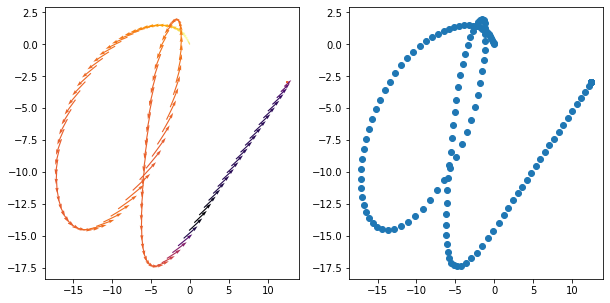

b


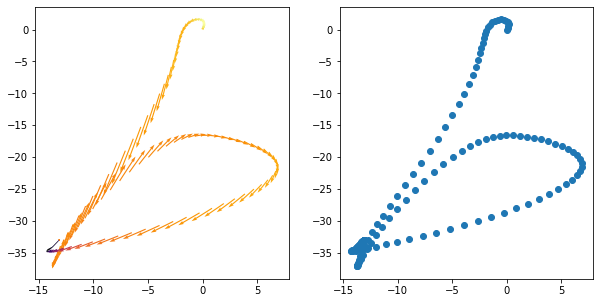

c


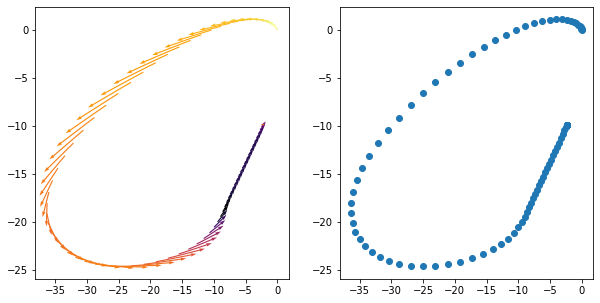

d


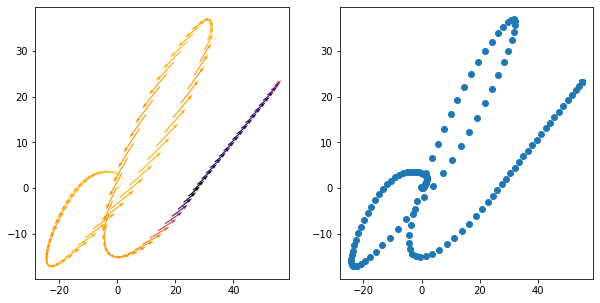

e


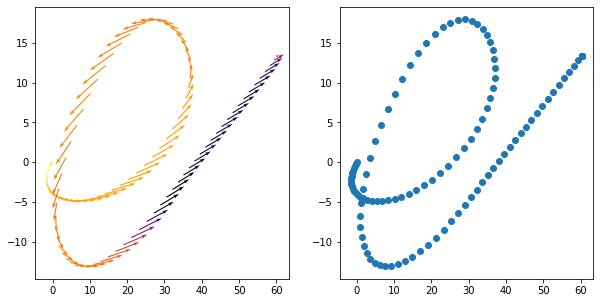

g


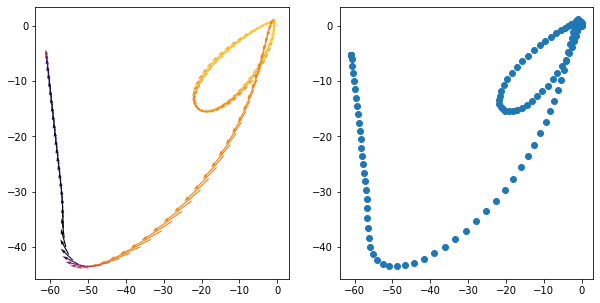

h


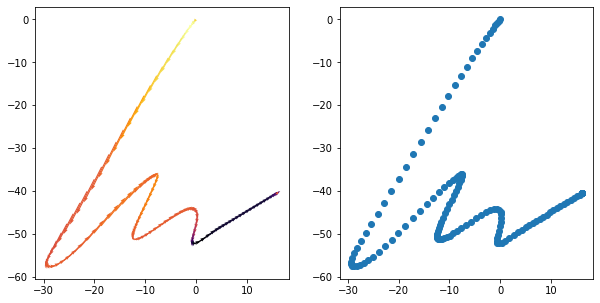

l


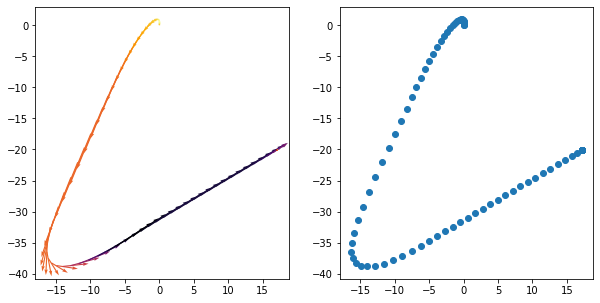

m


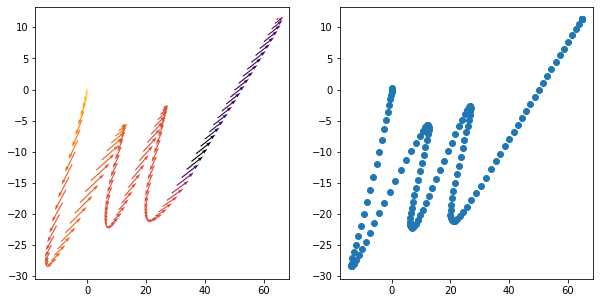

n


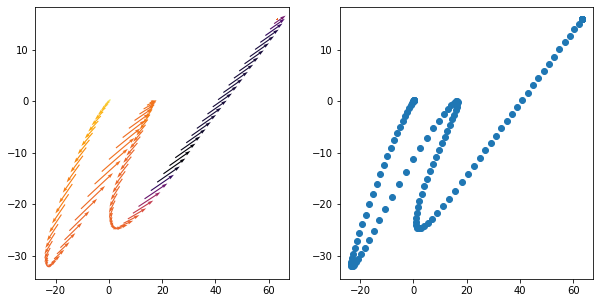

o


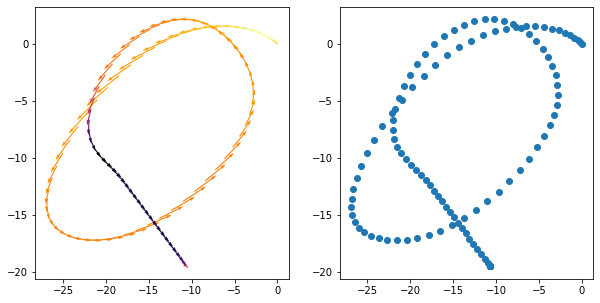

p


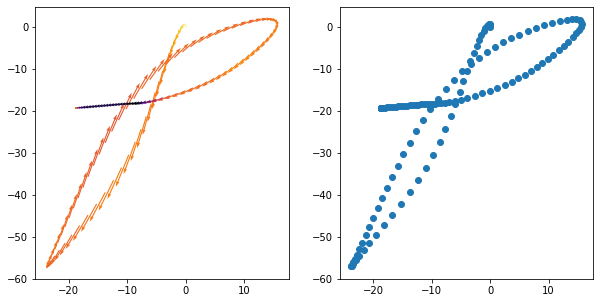

q


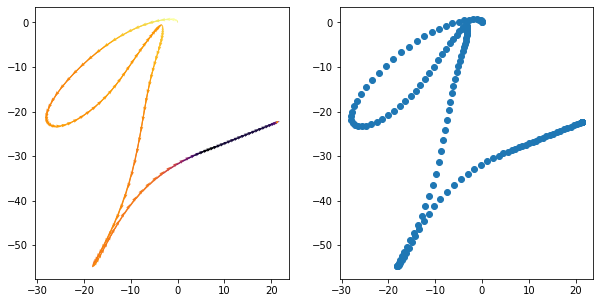

r


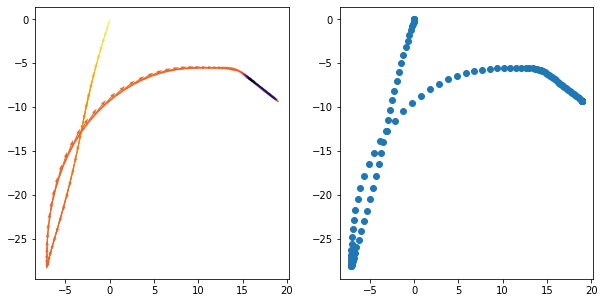

s


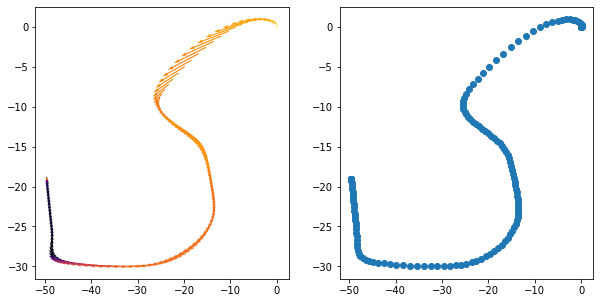

u


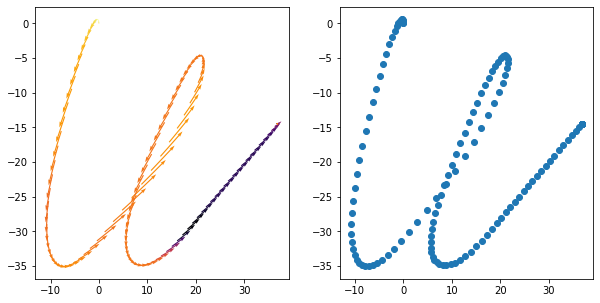

v


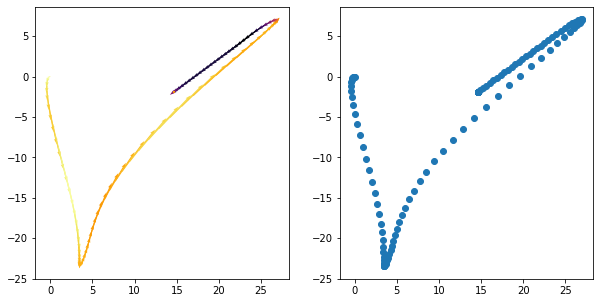

w


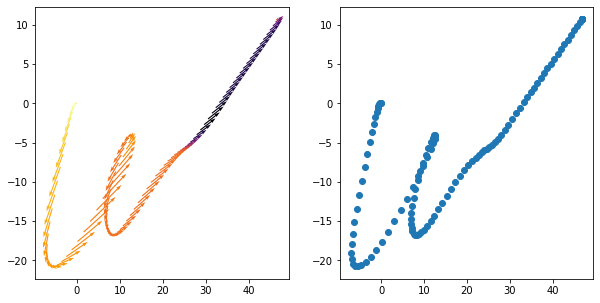

y


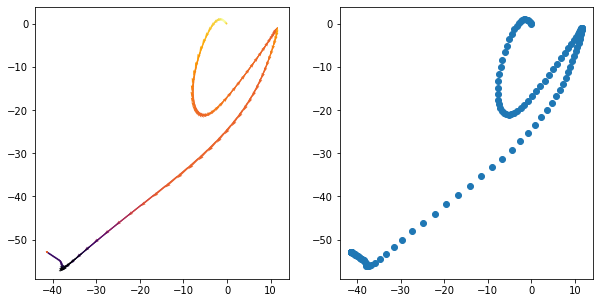

z


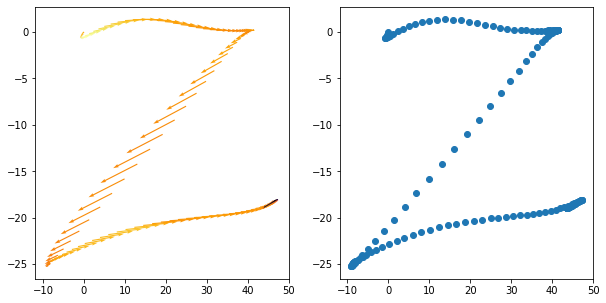

In [174]:
for i,class1 in enumerate(classes):
  indexes = np.where(train_labels==i)[0]
  np.random.seed(0)
  random_index = np.random.choice(indexes)
  print(class1)
  plot_charVector(train_inputs[random_index])

In [234]:
class mydataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.labels[index]
    return input,label


train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

train_dataset = mydataset(train_inputs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_inputs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

test_dataset = mydataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## define the network

In [254]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(704, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net().to(device)

In [255]:
#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch: 20, train loss: 2.920, val loss: 2.908
epoch: 40, train loss: 0.984, val loss: 0.949
epoch: 60, train loss: 0.299, val loss: 0.406
epoch: 80, train loss: 0.151, val loss: 0.260
epoch: 100, train loss: 0.094, val loss: 0.293
epoch: 120, train loss: 0.064, val loss: 0.194
epoch: 140, train loss: 0.042, val loss: 0.199

Finished Training


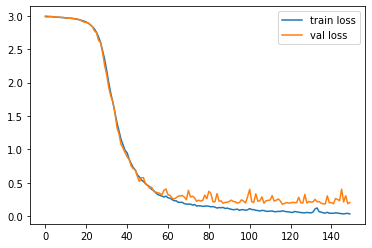

In [257]:
batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(150)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_loader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_loader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 20 == 19:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

evaluate

In [248]:
def evaluate(data_loader):
  y_true= []
  y_pred = []
  net.eval()

  for _, (inputBatch,labelBatch) in enumerate(data_loader):
    with torch.no_grad():
      inputBatch = inputBatch.float()
      labelBatch = labelBatch.type(torch.LongTensor)
      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)

      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
      inputBatch = inputBatch.float()
      outputBatch = net(inputBatch)
      
      for output,label in zip(outputBatch,labelBatch):
        output, label = output.cpu(), label.cpu()
        y_true.append(label)
        pred = np.argmax(output)
        y_pred.append(pred)

  print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [249]:
print("evaluation results on train data")
evaluate(train_loader)
print("evaluation results on test data")
evaluate(test_loader)

evaluation results on train data
              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000        56
           b     1.0000    1.0000    1.0000        61
           c     1.0000    1.0000    1.0000        57
           d     1.0000    1.0000    1.0000        55
           e     1.0000    1.0000    1.0000        74
           g     1.0000    1.0000    1.0000        46
           h     1.0000    0.9762    0.9880        42
           l     1.0000    1.0000    1.0000        63
           m     1.0000    1.0000    1.0000        51
           n     0.9804    0.9434    0.9615        53
           o     1.0000    1.0000    1.0000        52
           p     1.0000    1.0000    1.0000        55
           q     1.0000    1.0000    1.0000        44
           r     1.0000    1.0000    1.0000        43
           s     1.0000    1.0000    1.0000        47
           u     1.0000    0.9792    0.9895        48
           v     1.0000    1.0000    1.0000     

function to return patch

In [178]:
def patch(data,start,end,stride,channels):
  patch = []
  tmp = []

  l = len(data)
  np.random.seed(0)
  random_index = np.random.randint(l)
  sample = data[random_index]
  channels1 = sample
  
  for i in channels:
    tmp1 = []
    for j in range(start,end,stride):
      tmp1.append(channels1[i][j])
    tmp.append(tmp1)    

  tmp = np.array(tmp)
  patch.append(tmp)
  patch.append(random_index)
  patch = np.array(patch)

  return patch

[[-0.532881 -0.800545 -0.631835 -0.11461   0.252319  0.594397  1.198614
   1.752084  1.312562  0.276914 -0.340865 -0.488634 -0.230314  0.213631
   0.900964  1.611325]
 [-1.939234 -1.836776 -1.301238 -0.52089   0.087782  0.665052  1.284402
   1.531523  0.798482 -0.393603 -1.102029 -1.060351 -0.501484  0.083758
   0.601384  1.062945]]


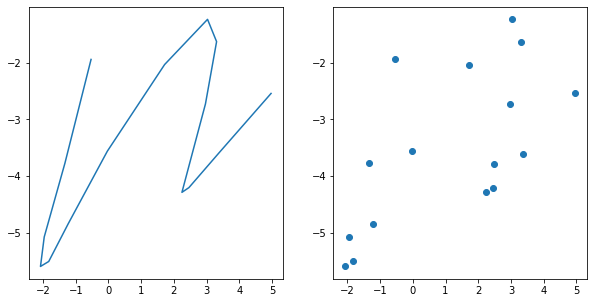

In [179]:
sample_patch = patch(train_inputs, start=10, end=90, stride=5, channels=[0,1])
print(sample_patch[0])
plot_char(sample_patch[0])